In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


In [13]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [14]:
# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define the tickers and time range
tickers = ['TSLA', 'BND', 'SPY']
start_date = '2015-01-01'
end_date = '2024-10-31'


In [15]:
# Download data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)

# Only keep the 'Close' prices for simplicity
close_prices = data['Close']

[*********************100%***********************]  3 of 3 completed


In [16]:
# Display the first few rows to check the data structure
print("Sample Data:")
print(close_prices.head())

### Data Cleaning and Understanding

# Check for missing values
print("\nMissing values per column:")
print(close_prices.isnull().sum())

# Fill any missing values using forward fill method
close_prices = close_prices.fillna(method='ffill')

Sample Data:
Ticker                           BND         SPY       TSLA
Date                                                       
2015-01-02 00:00:00+00:00  82.650002  205.429993  14.620667
2015-01-05 00:00:00+00:00  82.889999  201.720001  14.006000
2015-01-06 00:00:00+00:00  83.129997  199.820007  14.085333
2015-01-07 00:00:00+00:00  83.180000  202.309998  14.063333
2015-01-08 00:00:00+00:00  83.050003  205.899994  14.041333

Missing values per column:
Ticker
BND     0
SPY     0
TSLA    0
dtype: int64


/tmp/ipykernel_8503/215305780.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices = close_prices.fillna(method='ffill')


In [17]:
# Check data types and basic statistics
print("\nData Types:")
print(close_prices.dtypes)

print("\nBasic Statistics:")
print(close_prices.describe())


Data Types:
Ticker
BND     float64
SPY     float64
TSLA    float64
dtype: object

Basic Statistics:
Ticker          BND          SPY         TSLA
count   2474.000000  2474.000000  2474.000000
mean      80.316039   330.623634   111.438965
std        5.097592   103.324179   110.120450
min       68.040001   182.860001     9.578000
25%       76.379997   242.130001    17.066167
50%       81.410004   298.089996    25.043000
75%       84.010002   416.212502   216.865002
max       89.480003   584.590027   409.970001


In [18]:
scaled_data = (close_prices - close_prices.min()) / (close_prices.max() - close_prices.min())


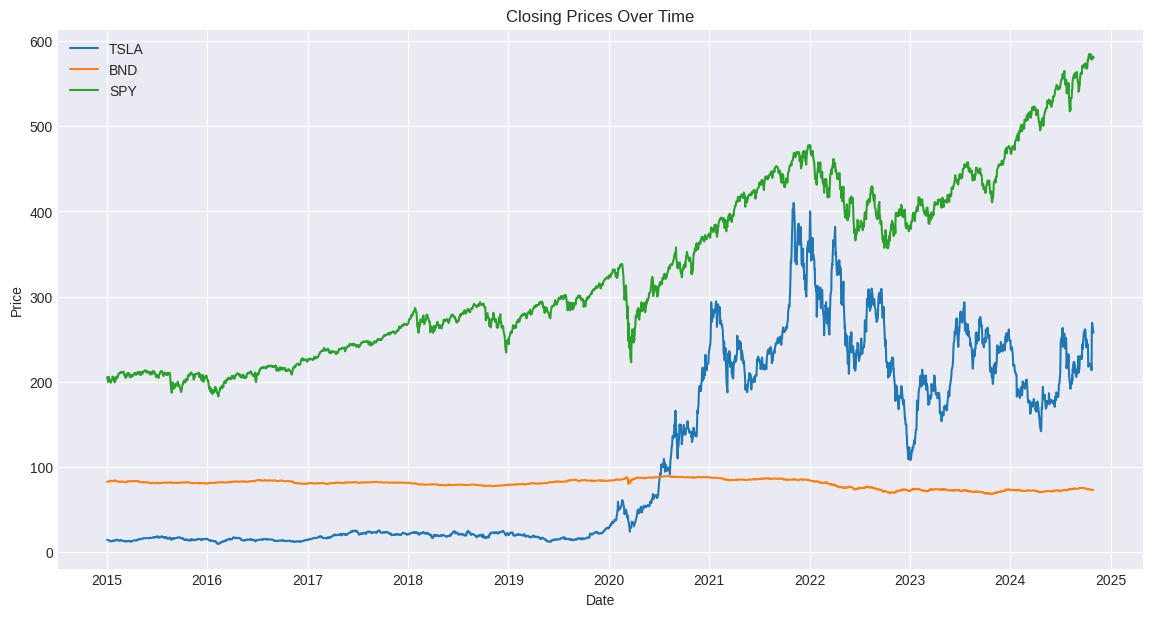

In [19]:
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_prices[ticker], label=ticker)
plt.title('Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [20]:
daily_returns = close_prices.pct_change().dropna()


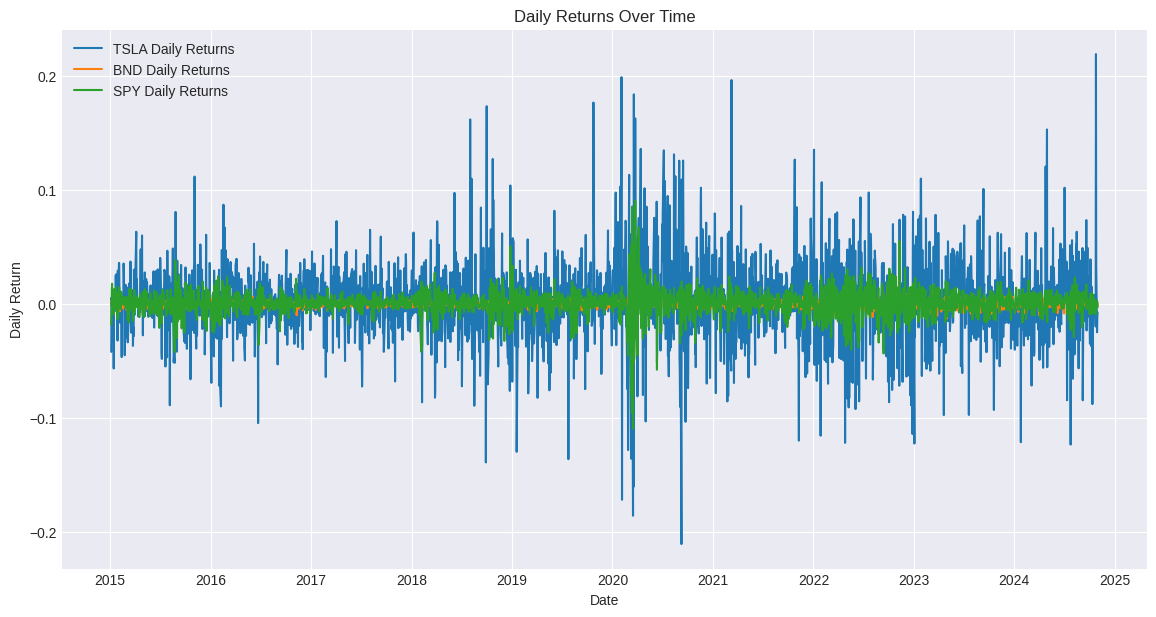

In [21]:
# Plot daily percentage change to observe volatility
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(daily_returns[ticker], label=f'{ticker} Daily Returns')
plt.title('Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

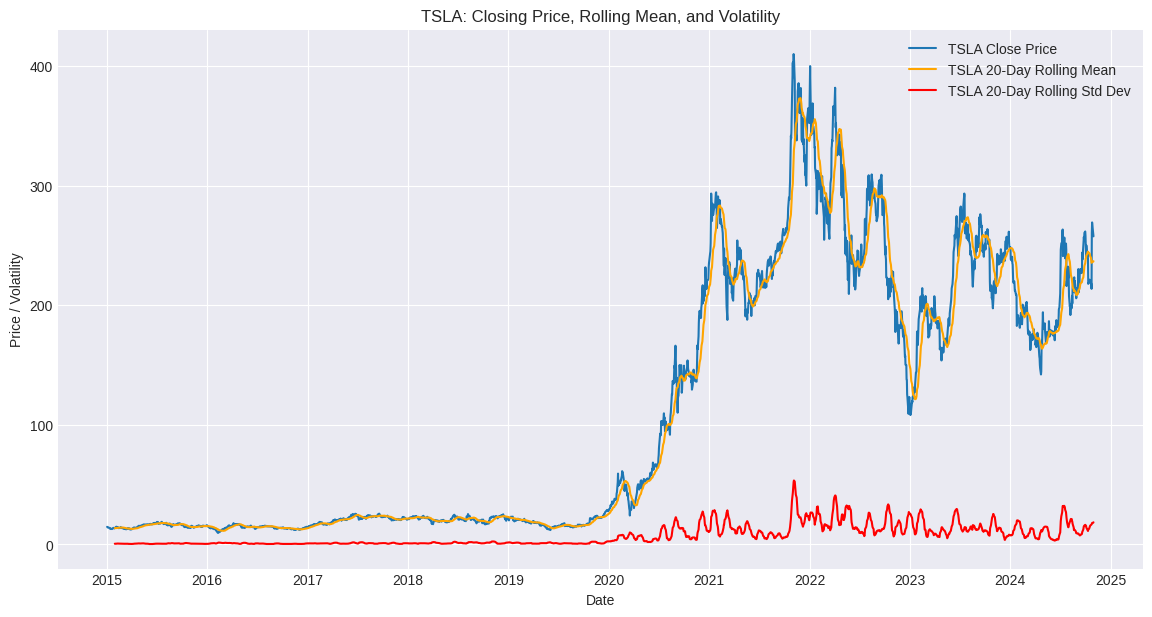

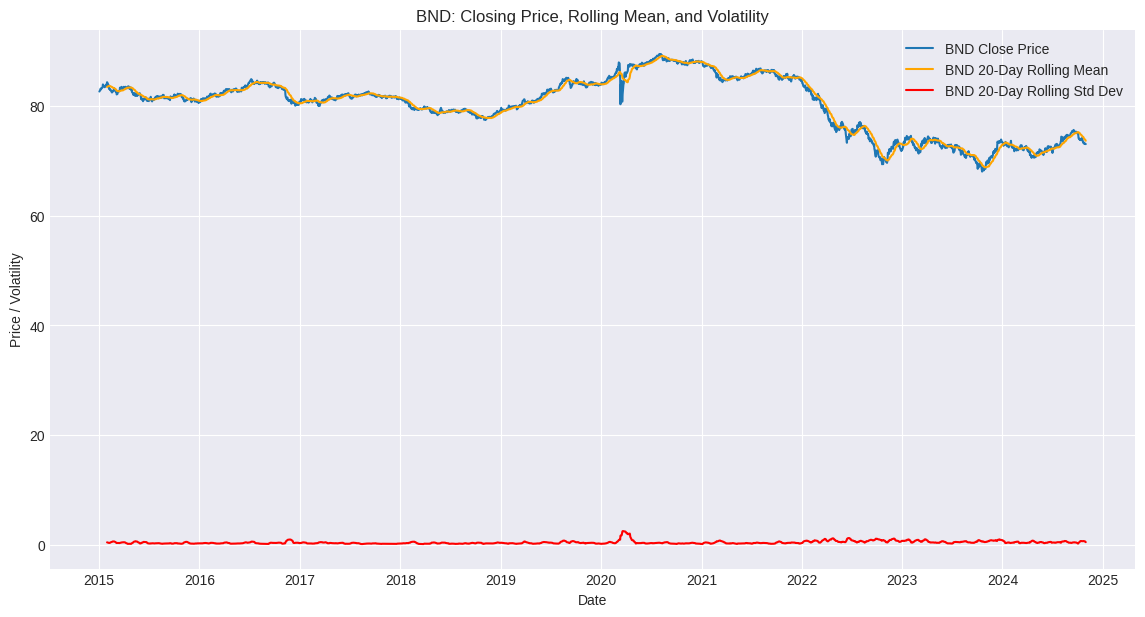

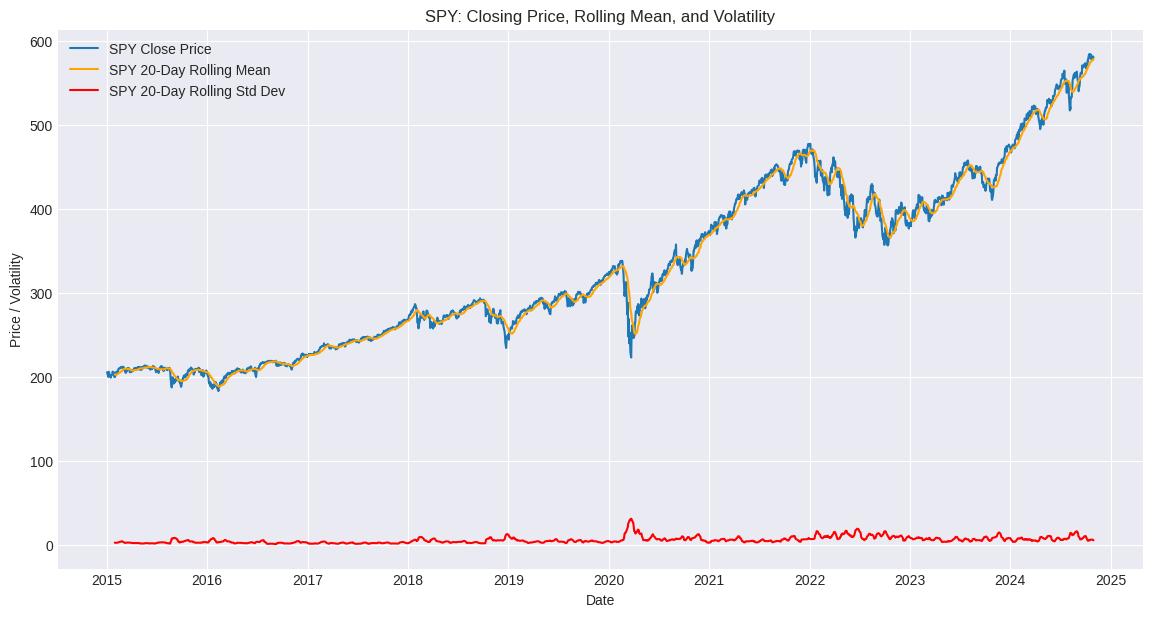

In [22]:
# Analyze volatility by calculating rolling means and standard deviations
window_size = 20  # 20-day rolling window for monthly trends
for ticker in tickers:
    rolling_mean = close_prices[ticker].rolling(window=window_size).mean()
    rolling_std = close_prices[ticker].rolling(window=window_size).std()
    
    plt.figure(figsize=(14, 7))
    plt.plot(close_prices[ticker], label=f'{ticker} Close Price')
    plt.plot(rolling_mean, label=f'{ticker} 20-Day Rolling Mean', color='orange')
    plt.plot(rolling_std, label=f'{ticker} 20-Day Rolling Std Dev', color='red')
    plt.title(f'{ticker}: Closing Price, Rolling Mean, and Volatility')
    plt.xlabel('Date')
    plt.ylabel('Price / Volatility')
    plt.legend()
    plt.show()

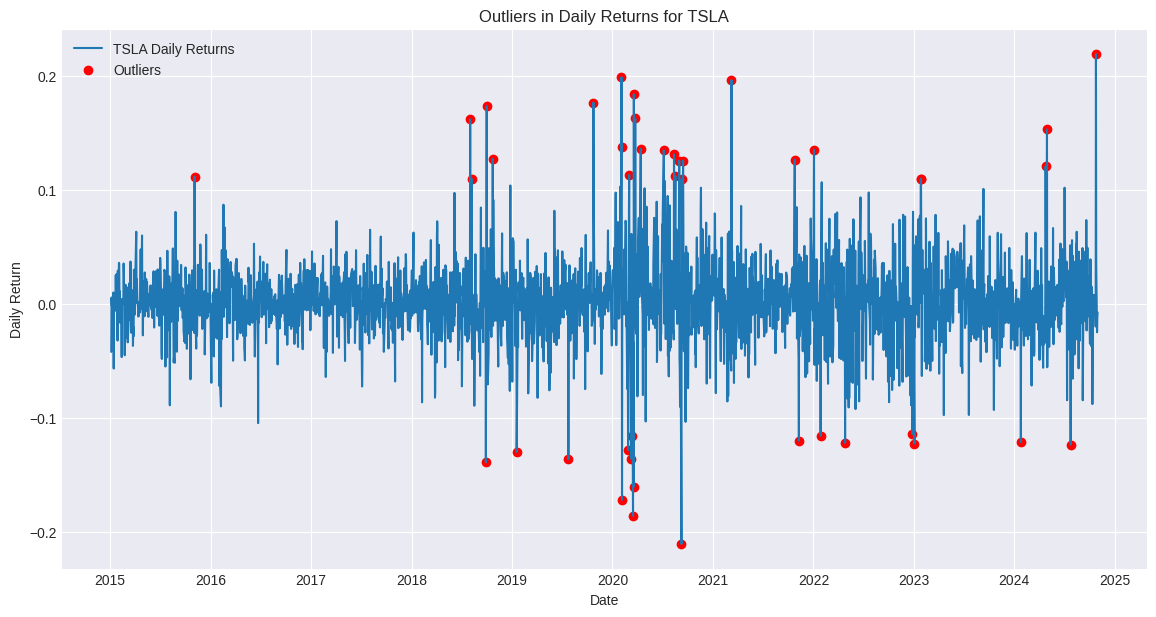

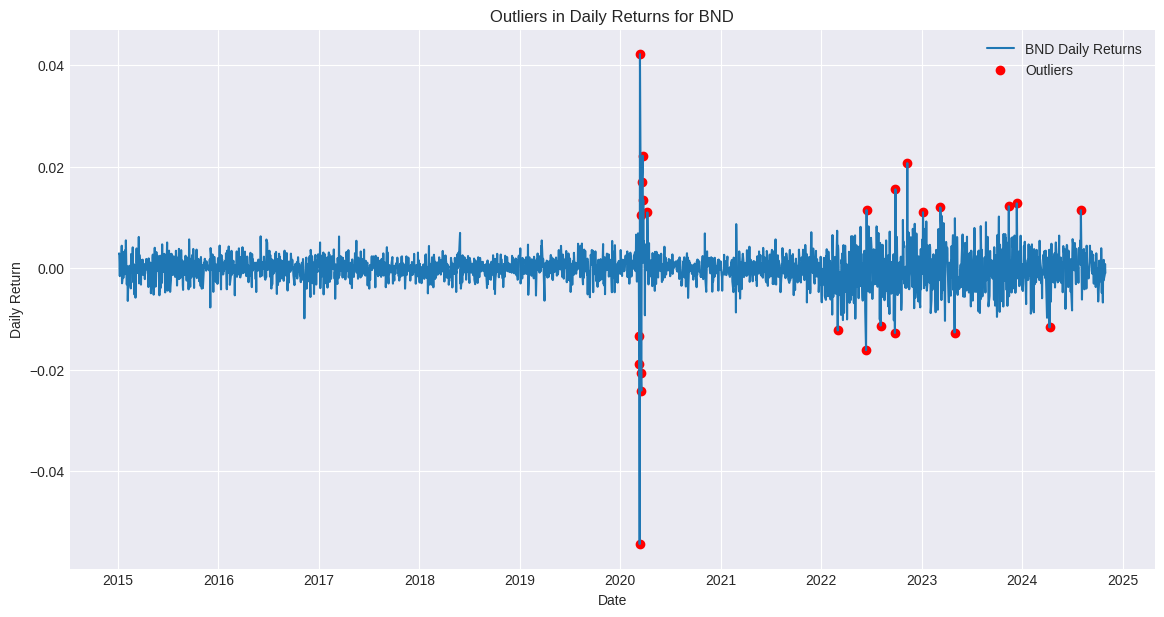

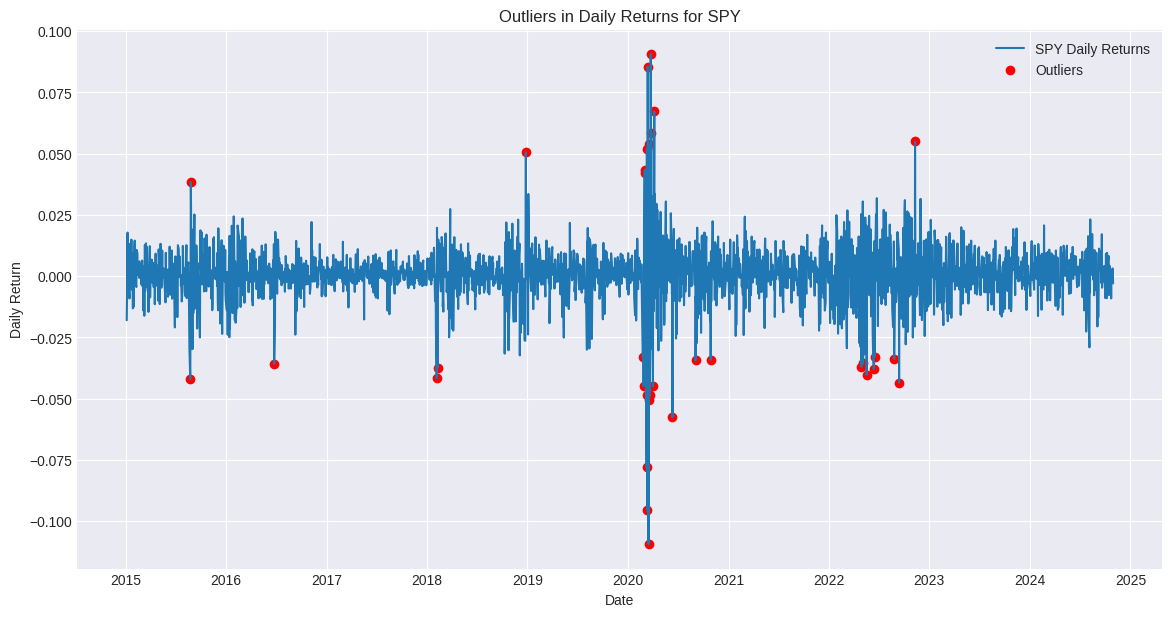

In [23]:
threshold = 3  # Common Z-score threshold for outlier detection
outliers = {}
for ticker in tickers:
    z_scores = (daily_returns[ticker] - daily_returns[ticker].mean()) / daily_returns[ticker].std()
    outliers[ticker] = daily_returns[ticker][(z_scores > threshold) | (z_scores < -threshold)]
    
    # Plot outliers
    plt.figure(figsize=(14, 7))
    plt.plot(daily_returns[ticker], label=f'{ticker} Daily Returns')
    plt.scatter(outliers[ticker].index, outliers[ticker], color='red', label='Outliers')
    plt.title(f'Outliers in Daily Returns for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()

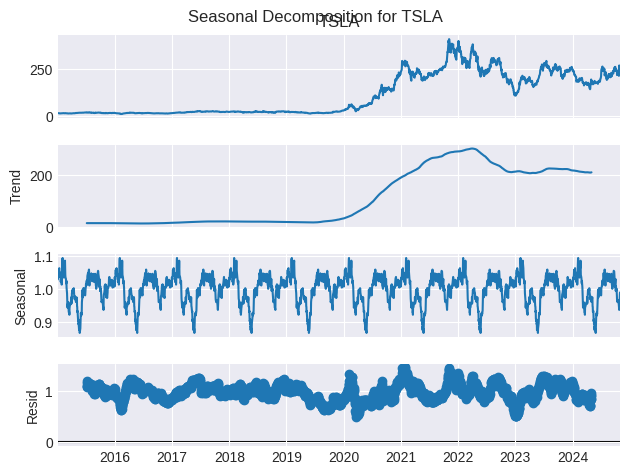

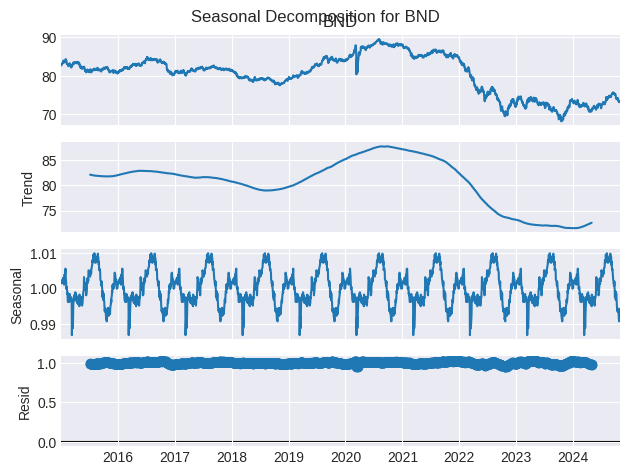

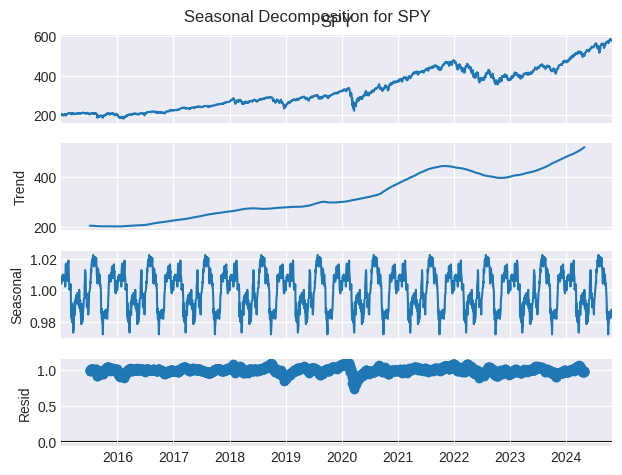

In [24]:
# Decompose the time series into trend, seasonal, and residual components for each asset
decompose_results = {}
for ticker in tickers:
    result = seasonal_decompose(close_prices[ticker].dropna(), model='multiplicative', period=252)  # assuming annual seasonality (252 trading days)
    decompose_results[ticker] = result
    
    # Plot decomposition
    result.plot()
    plt.suptitle(f'Seasonal Decomposition for {ticker}')
    plt.show()


In [25]:
confidence_level = 0.05  # VaR at 95% confidence
sharpe_ratios = {}
var_values = {}

for ticker in tickers:
    mean_return = daily_returns[ticker].mean()
    std_dev = daily_returns[ticker].std()
    
    # VaR calculation (assuming normal distribution of returns)
    var_values[ticker] = mean_return + std_dev * np.percentile(daily_returns[ticker], confidence_level * 100)
    
    # Sharpe Ratio calculation (risk-free rate assumed to be 0 for simplicity)
    sharpe_ratios[ticker] = mean_return / std_dev
    
    print(f"{ticker} - VaR (95%): {var_values[ticker]}, Sharpe Ratio: {sharpe_ratios[ticker]}")



TSLA - VaR (95%): -3.606412120705279e-05, Sharpe Ratio: 0.05024972073570676
BND - VaR (95%): -6.14574958180473e-05, Sharpe Ratio: -0.01268543406001066
SPY - VaR (95%): 0.0002947334357933921, Sharpe Ratio: 0.04315448209069543


In [26]:
# Display computed insights
print("\nKey Insights:")
print("1. Tesla (TSLA): High volatility with potential high returns.")
print("2. BND: Stability and low volatility; low risk.")
print("3. SPY: Moderate risk and diversified exposure to the broader market.")

print("\nSummary of VaR and Sharpe Ratios:")
print("Value at Risk (VaR) at 95% confidence level:")
print(var_values)
print("Sharpe Ratios (higher is better):")
print(sharpe_ratios)



Key Insights:
1. Tesla (TSLA): High volatility with potential high returns.
2. BND: Stability and low volatility; low risk.
3. SPY: Moderate risk and diversified exposure to the broader market.

Summary of VaR and Sharpe Ratios:
Value at Risk (VaR) at 95% confidence level:
{'TSLA': np.float64(-3.606412120705279e-05), 'BND': np.float64(-6.14574958180473e-05), 'SPY': np.float64(0.0002947334357933921)}
Sharpe Ratios (higher is better):
{'TSLA': np.float64(0.05024972073570676), 'BND': np.float64(-0.01268543406001066), 'SPY': np.float64(0.04315448209069543)}
